In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from aux import get_c_mean_p, get_c_spd, gsoftmax
from mft import MFT

from disp import set_plot

In [2]:
# numeric params for computing MF quantities
DX = .01
X_MIN = -30
X_MAX = 200

mft = MFT(X_MIN, X_MAX, DX)

In [3]:
D = 16

mself = np.eye(D, dtype=bool)
mseq = np.diag(np.ones(D-1), -1).astype(bool)
mseq[0, -1] = True  # periodic

t_max = 200
t = np.arange(t_max)

In [4]:
A = np.arange(0, 2*np.pi, 2*np.pi/D)

# Mean-driven sequence network (starting from mean-self-coupled network)

In [6]:
# mean-driven network
MU_J_MD = np.nan*np.zeros((D, D))
SGM_J_MD = np.nan*np.zeros((D, D))

MU_J_MD[mself] = 3
MU_J_MD[~mself] = 0
MU_J_MD[mseq] = 2.3

SGM_J_MD[mself] = 1
SGM_J_MD[~mself] = 1
SGM_J_MD[mseq] = 1

r_0 = .05*np.random.rand(D)
r_0[:10] += 1
r_0 /= r_0.sum()

rs_md = np.nan*np.zeros((t_max, D))
rs_md[0, :] = r_0

for t_ in t[1:]:
    rs_md[t_, :] = mft.alph(rs_md[t_-1, :], u=0, v=0, D=D, mu_j=MU_J_MD, sgm_j=SGM_J_MD)

    
# fluctuation-driven network
MU_J_FD = np.nan*np.zeros((D, D))
SGM_J_FD = np.nan*np.zeros((D, D))

MU_J_FD[mself] = 0
MU_J_FD[~mself] = 0
MU_J_FD[mseq] = 0

SGM_J_FD[mself] = 10
SGM_J_FD[~mself] = 1
SGM_J_FD[mseq] = 4.2

r_0 = .05*np.random.rand(D)
r_0[:10] += 1
r_0 /= r_0.sum()

rs_fd = np.nan*np.zeros((t_max, D))
rs_fd[0, :] = r_0

for t_ in t[1:]:
    rs_fd[t_, :] = mft.alph(rs_fd[t_-1, :], u=0, v=0, D=D, mu_j=MU_J_FD, sgm_j=SGM_J_FD)

In [7]:
# estimate speeds
c_mean_mds = get_c_mean_p(A, rs_md)
c_mean_fds = get_c_mean_p(A, rs_fd)

In [8]:
t_start = 50
t_c_mean_0_md = t_start + np.argmin(np.abs(c_mean_mds[t_start:]))
t_c_mean_0_fd = t_start + np.argmin(np.abs(c_mean_fds[t_start:]))

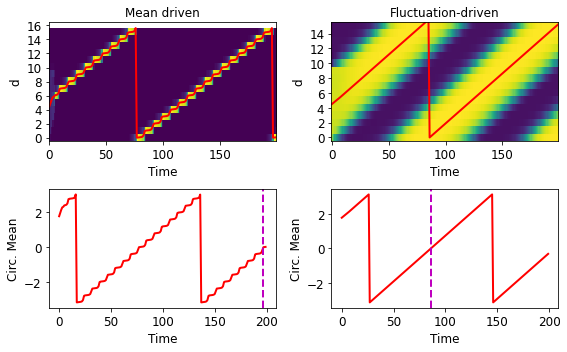

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), tight_layout=True)

axs[0, 0].matshow(rs_md.T, origin='lower')
axs[0, 0].set_aspect('auto')
axs[0, 0].plot((c_mean_mds % (2*np.pi))*D/(2*np.pi), c='r', lw=2)

axs[0, 0].xaxis.tick_bottom()
set_plot(axs[0, 0], x_label='Time', y_label='d', title='Mean driven')

axs[1, 0].plot(c_mean_mds, c='r', lw=2)
axs[1, 0].axvline(t_c_mean_0_md, c='m', lw=2, ls='--')

set_plot(axs[1, 0], x_label='Time', y_label='Circ. Mean')


axs[0, 1].matshow(rs_fd.T, origin='lower')
axs[0, 1].set_aspect('auto')
axs[0, 1].plot((c_mean_fds % (2*np.pi))*D/(2*np.pi), c='r', lw=2)

axs[0, 1].xaxis.tick_bottom()
set_plot(axs[0, 1], y_lim=(-.5, 15.5), x_label='Time', y_label='d', title='Fluctuation-driven')

axs[1, 1].plot(c_mean_fds, c='r', lw=2)
axs[1, 1].axvline(t_c_mean_0_fd, c='m', lw=2, ls='--')

set_plot(axs[1, 1], x_label='Time', y_label='Circ. Mean')

# Sample finite network activity at specific targ circular mean

In [11]:
C_MEAN_TARGS = np.linspace(0, np.pi/D, 9)
NTR = 30
N = 3000

P_CORRUPT = .5


labels = ['md', 'fd']

c_means_all = [c_mean_mds, c_mean_fds]
rs_all = [rs_md, rs_fd]

MU_JS = [MU_J_MD, MU_J_FD]
SGM_JS = [SGM_J_MD, SGM_J_FD]

r_finites = {label: np.nan*np.zeros((len(C_MEAN_TARGS), NTR, D)) for label in labels}
c_mean_finites = {label: np.nan*np.zeros((len(C_MEAN_TARGS), NTR)) for label in labels}

for ccmt, c_mean_targ in enumerate(C_MEAN_TARGS):
    print(f'c_mean_targ = {c_mean_targ:.3f}')
    
    for label, c_means, rs, MU_J, SGM_J in zip(labels, c_means_all, rs_all, MU_JS, SGM_JS):
    
        # find time of closest c-mean value
        t_ = t_start + np.argmin(np.abs(c_means[t_start:] - c_mean_targ))

        # find macrostate
        r = rs[t_, :]
        c_mean = get_c_mean_p(A, r)

        sys.stdout.write(f'c_mean_{label} = {c_mean:.3f} ')
        
        # get input means and variances
        mu_d = D*(MU_J @ r)
        sgm_d = np.sqrt(D*((SGM_J**2)@r))
        
        for ctr in range(NTR):
            # sample inputs
            xs = np.random.normal(mu_d, sgm_d, (N, D))
            
            ys = gsoftmax(xs, g=np.inf)
            
            # corrupt spikes
            mcorrupt = np.random.rand(N) < P_CORRUPT
            ncorrupt = np.sum(mcorrupt)
            ys[mcorrupt, :] = gsoftmax(np.random.randn(ncorrupt, D), np.inf)
            
            r_finite = ys.mean(axis=0)
            r_finites[label][ccmt, ctr, :] = r_finite
            
            c_mean_finites[label][ccmt, ctr] = get_c_mean_p(A, r_finite)
        
    print('\n')

c_mean_targ = 0.000
c_mean_md = 0.000 c_mean_fd = 0.001 

c_mean_targ = 0.025
c_mean_md = 0.024 c_mean_fd = 0.001 

c_mean_targ = 0.049
c_mean_md = 0.059 c_mean_fd = 0.054 

c_mean_targ = 0.074
c_mean_md = 0.059 c_mean_fd = 0.054 

c_mean_targ = 0.098
c_mean_md = 0.136 c_mean_fd = 0.106 

c_mean_targ = 0.123
c_mean_md = 0.136 c_mean_fd = 0.106 

c_mean_targ = 0.147
c_mean_md = 0.136 c_mean_fd = 0.159 

c_mean_targ = 0.172
c_mean_md = 0.136 c_mean_fd = 0.159 

c_mean_targ = 0.196
c_mean_md = 0.136 c_mean_fd = 0.212 



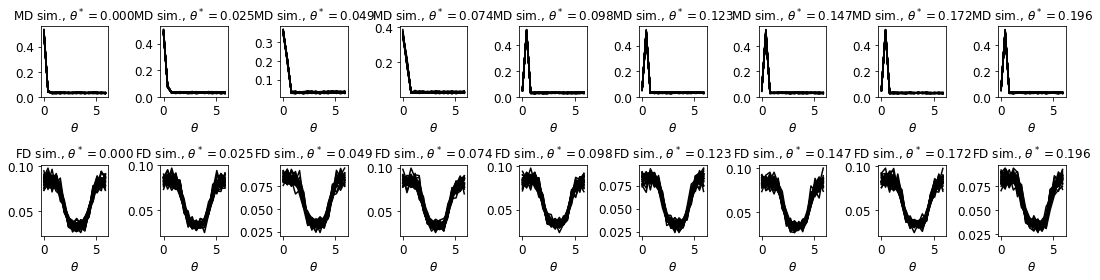

In [12]:
fig, axs = plt.subplots(2, len(C_MEAN_TARGS), figsize=(15, 4), tight_layout=True)
for label, ax_row in zip(labels, axs):
    for ccmt, c_mean_targ in enumerate(C_MEAN_TARGS):
        ax_row[ccmt].plot(A, r_finites[label][ccmt, :, :].T, c='k')
        set_plot(ax_row[ccmt], x_label=r'$\theta$', title=f'{label.upper()} sim., ' + r'$\theta^* = $' + f'{c_mean_targ:.3f}')

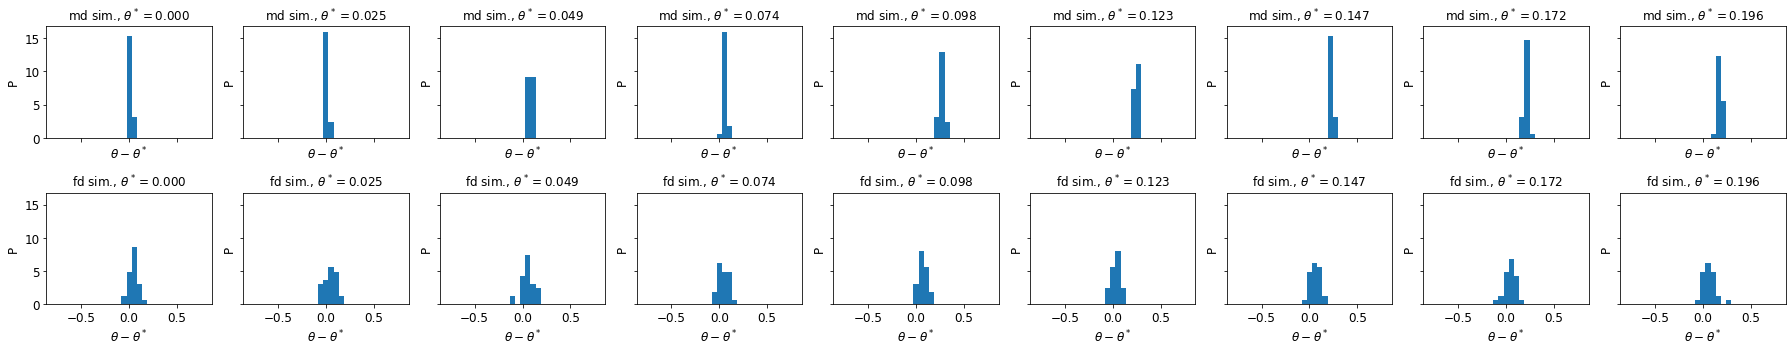

In [13]:
fig, axs = plt.subplots(2, len(C_MEAN_TARGS), figsize=(25, 5), tight_layout=True, sharex=True, sharey=True)
for label, ax_row in zip(labels, axs):
    for ccmt, c_mean_targ in enumerate(C_MEAN_TARGS):
        ax = ax_row[ccmt]
        c_mean_finite = c_mean_finites[label][ccmt, :]
        diffs = np.arctan2(np.sin(c_mean_finite-c_mean_targ), np.cos(c_mean_finite-c_mean_targ))
        ax.hist(diffs, bins=np.linspace(-np.pi/4, np.pi/4, 30), density=True)
        
        set_plot(ax, x_label=r'$\theta - \theta^*$', y_label='P', title=f'{label} sim., ' + r'$\theta^* = $' + f'{c_mean_targ:.3f}')